In [1]:
import os
# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.0'
spark_version = 'spark-3.0.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 http

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-02-22 00:24:08--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.1s    

2021-02-22 00:24:08 (6.59 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz"
spark.sparkContext.addFile(url)


In [5]:
# Read in the Review dataset as a DataFrame
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("amazon_reviews_us_Furniture_v1_00.tsv.gz"), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   24509695|R3VR960AHLFKDV|B004HB5E0E|     488241329|Shoal Creek Compu...|       Furniture|          4|            0|          0|   N|                Y|... desk is very ...|This desk is very...| 2015-08-31|
|         US|   34731776|R16LGVMFKIUT0G|B0042TNMMS|     205864445|Dorel Home Produc...|       Furniture|          5|    

In [6]:
# Create the vine_table. DataFrame
vine_df = df.select(["review_id","star_rating","helpful_votes","total_votes","vine","verified_purchase"])
vine_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R3VR960AHLFKDV|          4|            0|          0|   N|                Y|
|R16LGVMFKIUT0G|          5|            0|          0|   N|                Y|
|R1AIMEEPYHMOE4|          5|            1|          1|   N|                Y|
|R1892CCSZWZ9SR|          3|            0|          0|   N|                Y|
|R285P679YWVKD1|          3|            0|          0|   N|                N|
| RLB33HJBXHZHU|          5|            0|          0|   N|                Y|
|R1VGTZ94DBAD6A|          5|            2|          2|   N|                Y|
|R168KF82ICSOHD|          5|            0|          0|   N|                Y|
|R20DIYIJ0OCMOG|          5|            0|          0|   N|                Y|
| RD46RNVOHNZSC|          5|            0|          0|   N|     

In [7]:
total_votes_df = vine_df.filter("total_votes >= 20")
total_votes_df.show(20)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RL8D0KJ0J9L0O|          5|          152|        165|   N|                Y|
|R1BEINAIQFBRJC|          5|           21|         23|   N|                Y|
|R2L59KIJH302P9|          4|           26|         26|   N|                Y|
| RR99CPG695T0I|          5|          215|        248|   N|                N|
|R1XQNKKUPCMWVO|          5|           43|         44|   N|                Y|
|R3JUXVCT1NSK2A|          3|           25|         26|   N|                Y|
|R3GNSIFV1J2Y2B|          1|           15|         60|   N|                N|
| RTCRZARYY4LXX|          5|           52|         54|   N|                Y|
|R3OFB4P7Y8WR27|          1|           15|         26|   N|                Y|
|R3MTAYGQM25N63|          4|           58|         59|   N|     

In [8]:
helpful_votes_df = total_votes_df.filter("(helpful_votes/total_votes) >= .5")
helpful_votes_df.show(20)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RL8D0KJ0J9L0O|          5|          152|        165|   N|                Y|
|R1BEINAIQFBRJC|          5|           21|         23|   N|                Y|
|R2L59KIJH302P9|          4|           26|         26|   N|                Y|
| RR99CPG695T0I|          5|          215|        248|   N|                N|
|R1XQNKKUPCMWVO|          5|           43|         44|   N|                Y|
|R3JUXVCT1NSK2A|          3|           25|         26|   N|                Y|
| RTCRZARYY4LXX|          5|           52|         54|   N|                Y|
|R3OFB4P7Y8WR27|          1|           15|         26|   N|                Y|
|R3MTAYGQM25N63|          4|           58|         59|   N|                Y|
| RJNDSWES5ISZ7|          5|           78|         79|   N|     

In [9]:
vine_prg_paid_df= helpful_votes_df.filter("vine =='Y'")
vine_prg_paid_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R2BQOD1R0228FN|          3|           17|         26|   Y|                N|
| RC31RUPFOHBHQ|          4|          102|        117|   Y|                N|
| REN3N1WITLF1Y|          5|           33|         37|   Y|                N|
| R71RZQ9UZVG47|          4|           38|         47|   Y|                N|
|R38NMQBH88HLM6|          4|           18|         24|   Y|                N|
|R33FGX9EE3QVR6|          4|           26|         26|   Y|                N|
|R1KIOIK6WEYE59|          3|           19|         20|   Y|                N|
|R25X9BMOB3FD0E|          4|           32|         37|   Y|                N|
|R3VCKFCX2377Q2|          4|           95|        101|   Y|                N|
|R1E0OUG63HMSM4|          3|           58|         61|   Y|     

In [10]:
vine_prg_paid_df_N = helpful_votes_df.filter("vine =='N'")
vine_prg_paid_df_N.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RL8D0KJ0J9L0O|          5|          152|        165|   N|                Y|
|R1BEINAIQFBRJC|          5|           21|         23|   N|                Y|
|R2L59KIJH302P9|          4|           26|         26|   N|                Y|
| RR99CPG695T0I|          5|          215|        248|   N|                N|
|R1XQNKKUPCMWVO|          5|           43|         44|   N|                Y|
|R3JUXVCT1NSK2A|          3|           25|         26|   N|                Y|
| RTCRZARYY4LXX|          5|           52|         54|   N|                Y|
|R3OFB4P7Y8WR27|          1|           15|         26|   N|                Y|
|R3MTAYGQM25N63|          4|           58|         59|   N|                Y|
| RJNDSWES5ISZ7|          5|           78|         79|   N|     

In [11]:
total_paid_reviews = vine_prg_paid_df.count()
total_paid_reviews

136

In [12]:
total_unpaid_reviews=vine_prg_paid_df_N.count()
total_unpaid_reviews

18019

In [13]:
total_paid_5_star_reviews=vine_prg_paid_df.filter("star_rating == 5").count()
total_paid_5_star_reviews

74

In [14]:
total_unpaid_5_star_reviews=vine_prg_paid_df_N.filter("star_rating == 5").count()
total_unpaid_5_star_reviews

8482

In [15]:
percentage_paid_5_star_reviews=(total_paid_5_star_reviews/total_paid_reviews)*100
percentage_paid_5_star_reviews

54.41176470588235

In [16]:
percentage_unpaid_5_star_reviews=(total_unpaid_5_star_reviews/total_unpaid_reviews)*100
percentage_unpaid_5_star_reviews

47.072534546867196

#Additional Analysis for Deliverable 3

In [17]:
total_paid_4_star_reviews=vine_prg_paid_df.filter("star_rating == 4").count()
percentage_paid_4_star_reviews=(total_paid_4_star_reviews/total_paid_reviews)*100
percentage_paid_4_star_reviews

33.088235294117645

In [18]:
total_paid_3_star_reviews=vine_prg_paid_df.filter("star_rating == 3").count()
percentage_paid_3_star_reviews=(total_paid_3_star_reviews/total_paid_reviews)*100
percentage_paid_3_star_reviews

11.029411764705882

In [19]:
total_paid_2_star_reviews=vine_prg_paid_df.filter("star_rating == 2").count()
percentage_paid_2_star_reviews=(total_paid_2_star_reviews/total_paid_reviews)*100
percentage_paid_2_star_reviews

1.4705882352941175

In [20]:
total_paid_1_star_reviews=vine_prg_paid_df.filter("star_rating == 1").count()
percentage_paid_1_star_reviews=(total_paid_1_star_reviews/total_paid_reviews)*100
percentage_paid_1_star_reviews

0.0

In [21]:
total_unpaid_4_star_reviews=vine_prg_paid_df_N.filter("star_rating == 4").count()
percentage_unpaid_4_star_reviews=(total_unpaid_4_star_reviews/total_unpaid_reviews)*100
percentage_unpaid_4_star_reviews

17.192962983517397

In [22]:
total_unpaid_3_star_reviews=vine_prg_paid_df_N.filter("star_rating == 3").count()
percentage_unpaid_3_star_reviews=(total_unpaid_3_star_reviews/total_unpaid_reviews)*100
percentage_unpaid_3_star_reviews

9.3234918696931

In [23]:
total_unpaid_2_star_reviews=vine_prg_paid_df_N.filter("star_rating == 2").count()
percentage_unpaid_2_star_reviews=(total_unpaid_2_star_reviews/total_unpaid_reviews)*100
percentage_unpaid_2_star_reviews

7.081414062933571

In [24]:
total_unpaid_1_star_reviews=vine_prg_paid_df_N.filter("star_rating == 1").count()
percentage_unpaid_1_star_reviews=(total_unpaid_1_star_reviews/total_unpaid_reviews)*100
percentage_unpaid_1_star_reviews

19.32959653698873

Text(0, 0.5, 'Percentage of star rating')

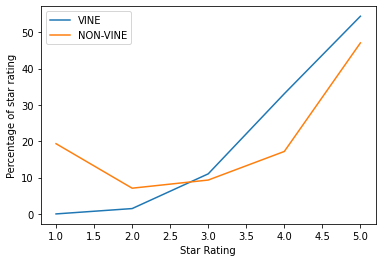

In [26]:

import pandas as pd
df = pd.DataFrame({
   'VINE': [percentage_paid_1_star_reviews, percentage_paid_2_star_reviews, percentage_paid_3_star_reviews, percentage_paid_4_star_reviews, percentage_paid_5_star_reviews],
 'NON-VINE': [percentage_unpaid_1_star_reviews, percentage_unpaid_2_star_reviews, percentage_unpaid_3_star_reviews, percentage_unpaid_4_star_reviews, percentage_unpaid_5_star_reviews]
 }, index=[1, 2, 3, 4, 5])
lines = df.plot.line()
lines.set_xlabel("Star Rating")
lines.set_ylabel("Percentage of star rating")
